# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
import os
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.callbacks import History 
import math
import cv2

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

Using TensorFlow backend.


### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training:
* Typical filename: 
    * ReadOut-xx_Watch-y_zzzz.jpg 
    * e.g. "ReadOut-54_Watch-4_1667.jpg"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **xx**          | readout value               | **to be learned** |
| y           | different analog watches    | ignored      |
| zzzz        | running number              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = cv2.imread(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

(2898, 32, 32, 3)
(2898, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Conv2D(64, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (5, 5), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(2))
model.summary()

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adadelta(), metrics = ["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          9248      
_________________________________________________________________
max_

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 30
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)

history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
290/290 [==============================] - 9s 31ms/step - loss: 0.1640 - acc: 0.8615 - val_loss: 0.0213 - val_acc: 0.9517
Epoch 2/30
290/290 [==============================] - 9s 31ms/step - loss: 0.0187 - acc: 0.9612 - val_loss: 0.0077 - val_acc: 0.9603
Epoch 3/30
290/290 [==============================] - 9s 32ms/step - loss: 0.0125 - acc: 0.9603 - val_loss: 0.0099 - val_acc: 0.9707
Epoch 4/30
290/290 [==============================] - 9s 32ms/step - loss: 0.0090 - acc: 0.9707 - val_loss: 0.0047 - val_acc: 0.9638
Epoch 5/30
290/290 [==============================] - 10s 33ms/step - loss: 0.0068 - acc: 0.9767 - val_loss: 0.0140 - val_acc: 0.9741
Epoch 6/30
290/290 [==============================] - 9s 32ms/step - loss: 0.0056 - acc: 0.9741 - val_loss: 0.0022 - val_acc: 0.9741
Epoch 7/30
290/290 [==============================] - 10s 34ms/step - loss: 0.0046 - acc: 0.9780 - val_loss: 0.0042 - val_acc: 0.9810
Epoch 8/30
290/290 

### Step 1: Learing result
 
* Visualization of the training and validation results

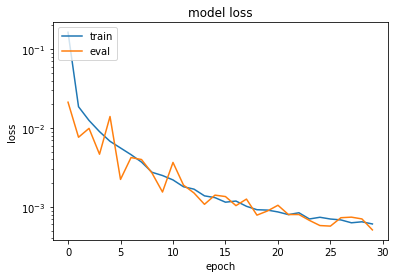

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 60
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)

history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)

Epoch 1/60
290/290 [==============================] - 13s 45ms/step - loss: 0.0324 - acc: 0.9435 - val_loss: 0.0046 - val_acc: 0.9741
Epoch 2/60
290/290 [==============================] - 13s 44ms/step - loss: 0.0058 - acc: 0.9685 - val_loss: 0.0059 - val_acc: 0.9776
Epoch 3/60
290/290 [==============================] - 15s 51ms/step - loss: 0.0039 - acc: 0.9694 - val_loss: 0.0037 - val_acc: 0.9655
Epoch 4/60
290/290 [==============================] - 15s 50ms/step - loss: 0.0031 - acc: 0.9724 - val_loss: 0.0037 - val_acc: 0.9759
Epoch 5/60
290/290 [==============================] - 14s 49ms/step - loss: 0.0028 - acc: 0.9733 - val_loss: 0.0027 - val_acc: 0.9828
Epoch 6/60
290/290 [==============================] - 14s 47ms/step - loss: 0.0024 - acc: 0.9797 - val_loss: 0.0015 - val_acc: 0.9897
Epoch 7/60
290/290 [==============================] - 13s 44ms/step - loss: 0.0020 - acc: 0.9810 - val_loss: 0.0017 - val_acc: 0.9862
Epoch 8/60
290/290 [==============================] - 13s 45ms

Epoch 38/60
290/290 [==============================] - 10s 36ms/step - loss: 6.7043e-04 - acc: 0.9871 - val_loss: 6.8589e-04 - val_acc: 0.9879
Epoch 39/60
290/290 [==============================] - 11s 39ms/step - loss: 6.5876e-04 - acc: 0.9879 - val_loss: 7.7216e-04 - val_acc: 0.9810
Epoch 40/60
290/290 [==============================] - 12s 42ms/step - loss: 6.6784e-04 - acc: 0.9879 - val_loss: 6.6585e-04 - val_acc: 0.9948
Epoch 41/60
290/290 [==============================] - 13s 44ms/step - loss: 6.6075e-04 - acc: 0.9866 - val_loss: 6.2369e-04 - val_acc: 0.9914
Epoch 42/60
290/290 [==============================] - 12s 41ms/step - loss: 7.2125e-04 - acc: 0.9884 - val_loss: 8.2589e-04 - val_acc: 0.9914
Epoch 43/60
290/290 [==============================] - 12s 41ms/step - loss: 6.2218e-04 - acc: 0.9879 - val_loss: 8.0450e-04 - val_acc: 0.9897
Epoch 44/60
290/290 [==============================] - 12s 41ms/step - loss: 6.4749e-04 - acc: 0.9875 - val_loss: 7.1999e-04 - val_acc: 0.9931

### Overall Learing results (Step 1 & Step 2)

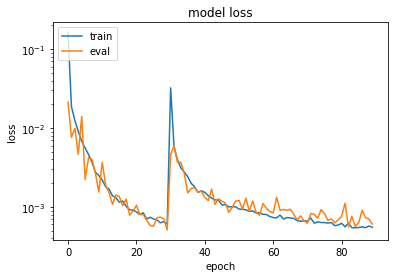

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])
val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])

plt.semilogy(loss_ges)
plt.semilogy(val_loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
i = 0

for aktfile in files:
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = cv2.imread(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    i+=1

res = np.asarray(res)
res_step_1 = res

In [9]:
np.savetxt("foo.csv", res, delimiter=";", fmt='%4.3f')

## Results

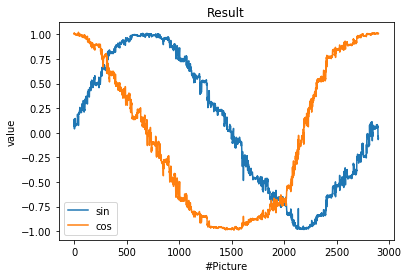

In [10]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

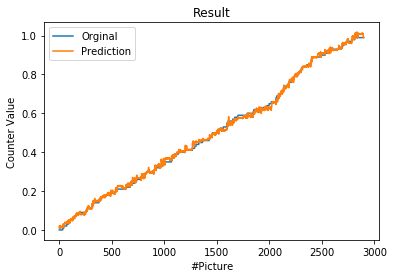

In [11]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

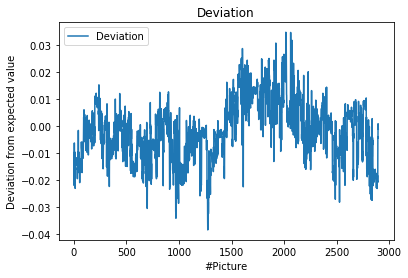

[-0.0017  0.0109 -0.0384  0.0347]


In [12]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [13]:
model.save("CNN_Analog-Readout_Version-2.1.1.h5")